In [1]:
import numpy as np
import yfinance as yf
import datetime as dt
import pandas as pd
import scipy.optimize as sc
import matplotlib.pyplot as plt 


In [2]:
def getData(tickers, startDate, endDate):
    '''
    type tickers: List[str]: A list of the tickers of assets
    type startDate: datetime: Start date of price data
    type endDate: datetime: End date of price data
    '''
    # Given tickers, we download market data from Yahoo Finance and calculate the mean daily return
    # of each asset and the covariance between assets.
    
    df = yf.download(tickers, start=startDate, end=endDate)['Adj Close']
    returns = df.pct_change()
    meanReturns = returns.mean()
    covariance = returns.cov()
    return meanReturns, covariance

def portfolioPerformance(weights, meanReturns, covariance):
    '''
    type weights: 1-d NumPy array: An array describing the proportion invested in each asset
    type meanReturns: 1-d NumPy array: An array of the mean daily return for each asset
    type covariance: 2-d NumPy array: Covariance between each asset
    '''
    # Given the mean daily return of each asset, the covariance between asset and the weightings
    # of a portfolio we can calculate the return of our portfolio and standard deviation.
    
    pReturn = np.sum(meanReturns*weights)*252
    pStandardDev = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))*252)
    return pReturn, pStandardDev

def sharpeRatio(weights, meanReturns, covariance, r):
    '''
    type weights: 1-d NumPy array: An array describing the proportion invested in each asset
    type meanReturns: 1-d NumPy array: An array of the mean daily return for each asset
    type covariance: 2-d NumPy array: Covariance between each asset
    type r: float: The risk-free interest rate
    '''
    # Given the weights of a portfolio, we can calculate the return and standard deviation of the
    # portfolio using portfolioPerformance and find the Sharpe ratio.
    
    pReturn, pStandardDev = portfolioPerformance(weights, meanReturns, covariance)
    # Returns the negative Sharpe ratio to turn a maximization problem into a minimization problem
    return -(pReturn-r)/pStandardDev

def maxSharpeRatio(meanReturns, covariance, r):
    '''
    type meanReturns: 1-d NumPy array: An array of the mean daily return for each asset
    type covariance: 2-d NumPy array: Covariance between each asset
    type r: float: The risk-free interest rate
    '''
    # We solve an optimisation problem: finding the weightings that minimizes the negative Sharpe ratio
    # (maximizes the Sharpe ratio) subject to weightings summing to one.
    
    init = len(meanReturns)*[1./len(meanReturns)]
    args = (meanReturns, covariance, r)
    bounds = ((0, 1) for _ in range(len(meanReturns)))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
    res = sc.minimize(sharpeRatio, init, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return res['fun'], res['x']

def portfolioVariance(weights, meanReturns, covariance):
    '''
    type weights: 1-d NumPy array: An array describing the proportion invested in each asset
    type meanReturns: 1-d NumPy array: An array of the mean daily return for each asset
    type covariance: 2-d NumPy array: Covariance between each asset
    '''
    # Given the weights of a portfolio, we return the standard deviation of the portfolio using 
    # portfolioPerformance.
    
    return portfolioPerformance(weights, meanReturns, covariance)[1]

def minVariance(meanReturns, covariance):
    '''
    type meanReturns: 1-d NumPy array: An array of the mean daily return for each asset
    type covariance: 2-d NumPy array: Covariance between each asset
    '''
    # We solve an optimisation problem: finding the weightings that minimizes the variance of the portfolio
    # subject to weightings summing to one.
    
    init = len(meanReturns)*[1./len(meanReturns)]
    args = (meanReturns, covariance)
    bounds = ((0, 1) for _ in range(len(meanReturns)))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
    res = sc.minimize(portfolioVariance, init, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return res['fun'], res['x']

def efficientPortfolio(meanReturns, covariance, target):
    '''
    type meanReturns: 1-d NumPy array: An array of the mean daily return for each asset
    type covariance: 2-d NumPy array: Covariance between each asset
    type target: float: Want to find the portfolio with the smallest variance that reaches this return target
    '''
    #  We solve an optimisation problem: finding the weightings that minimizes the variance of the portfolio
    # subject to weightings summing to one and the return of the portfolio exceeding the target.
    
    def portfolioReturn(weights):
        '''
        type weights: 1-d NumPy array: An array describing the proportion invested in each asset
        '''
        # Given the weights of a portfolio, we return the return of the portfolio using portfolioPerformance. 
        return portfolioPerformance(weights, meanReturns, covariance)[0]
    
    init = len(meanReturns)*[1./len(meanReturns)]
    args = (meanReturns, covariance)
    bounds = ((0, 1) for _ in range(len(meanReturns)))
    constraints = ({'type': 'ineq', 'fun': lambda x: portfolioReturn(x)-target}, {'type': 'eq', 'fun': lambda x: np.sum(x)-1})
    res = sc.minimize(portfolioVariance, init, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return res['fun'], res['x']
    
def efficientFrontier(meanReturns, covariance, r):
    '''
    type meanReturns: 1-d NumPy array: An array of the mean daily return for each asset
    type covariance: 2-d NumPy array: Covariance between each asset
    type r: float: The risk-free interest rate
    '''
    # Using maxSharpeRatio and minVariance, we find the two portfolios that maximimize the Sharpe ratio and minimise variance.
    # We use these weightings to find the returns and standard deviations of each portfolio. For each return between the return
    # of the minVariance portfolio and maxSharpeRatio portfolio, we compute the efficient portfolio using efficientFrontier. This
    # is stored in an array and displayed as a line plot.
    
    res = maxSharpeRatio(meanReturns, covariance, r)
    pMaxSharpeRatioReturn, pMaxSharpeRatioStandardDev = portfolioPerformance(res[1], meanReturns, covariance)
    pMaxSharpeRatio = pd.DataFrame(res[1], index=meanReturns.index, columns=['Weighting'])
    
    res = minVariance(meanReturns, covariance)
    pMinVarianceReturn, pMinVarianceStandardDev = portfolioPerformance(res[1], meanReturns, covariance)
    pMinVariance = pd.DataFrame(res[1], index=meanReturns.index, columns=['Weighting'])
    
    efficientFrontier = []
    target = np.linspace(pMinVarianceReturn, pMaxSharpeRatioReturn, 30)
    for i in range(len(target)):
        # Conversion from decimals to percentages
        efficientFrontier.append(efficientPortfolio(meanReturns, covariance, target[i])[0]*100)
        target[i] = target[i]*100
    
    csfont = {'fontname':'Helvetica'}
    fig, ax = plt.subplots(figsize=(14, 6.5))
    ax.plot(efficientFrontier, list(target), color='black', linestyle='dashed', label='Efficient Frontier')
    ax.plot([pMaxSharpeRatioStandardDev*100], [pMaxSharpeRatioReturn*100], linestyle='', marker='o', color='red', label='Maximum Sharpe Ratio')
    ax.plot([pMinVarianceStandardDev*100], [pMinVarianceReturn*100], linestyle='', marker='o', color='green', label='Minimum Volatility')
    ax.set_title('Portfolio Optimisation with Efficient Frontier', fontsize=16, **csfont)
    ax.set_xlabel('Annualised Volatility (%)', fontsize=14, **csfont)
    ax.set_ylabel('Annualised Return (%)', fontsize=14, **csfont)
    ax.set_xticklabels(np.round(efficientFrontier, 2))
    ax.set_yticklabels(np.round(target, 2))
    plt.legend()
    plt.savefig('Efficient_Frontier_Curve.png', dpi=800)
    plt.show()


[*********************100%%**********************]  5 of 5 completed
/var/folders/mv/h7wy_67d4rl802h9yk6t4zv80000gn/T/ipykernel_3713/3410849082.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(efficientFrontier, 2))
/var/folders/mv/h7wy_67d4rl802h9yk6t4zv80000gn/T/ipykernel_3713/3410849082.py:143: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(target, 2))


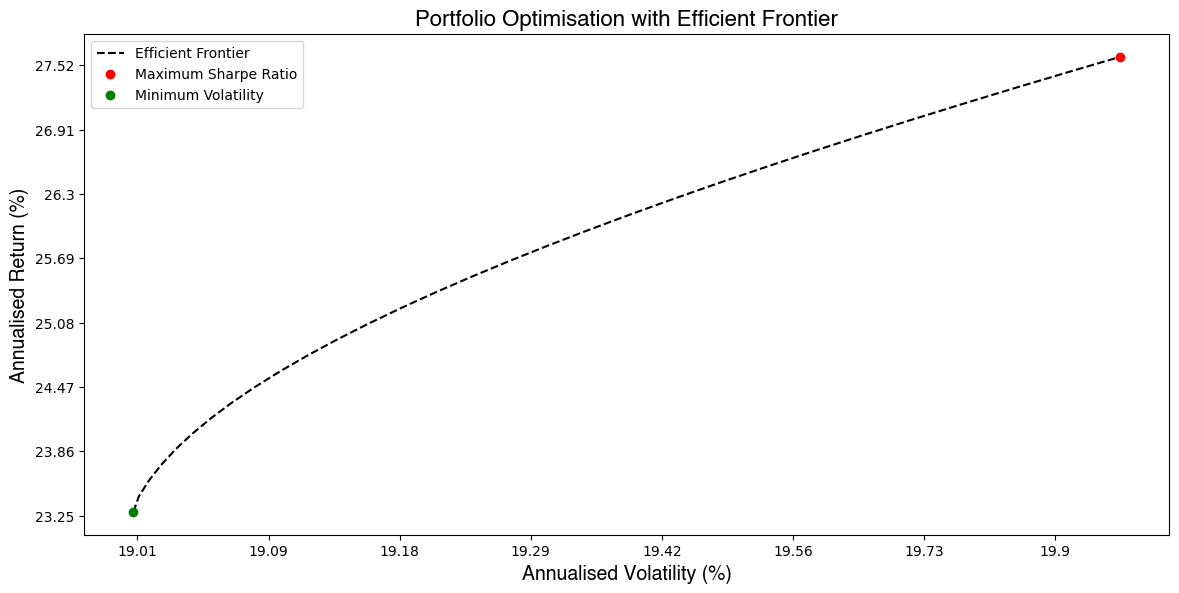

In [3]:
meanReturns, covariance = getData(['MSFT', 'META', 'AAPL', 'AMZN', 'GLE.PA'], dt.datetime.now()-dt.timedelta(days=365*2), dt.datetime.now())
efficientFrontier(meanReturns, covariance, 0.01)
